Model based on Random Forest & Decision Tree
#Cross Validation Included

In [129]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

# Load your marijuana project data from a CSV file
# Replace 'marijuana_data.csv' with the actual path to your CSV file
df = pd.read_csv('https://raw.githubusercontent.com/zeroday-zaddy/cs422-project/main/data/strains_cleaned.csv')


# Drop rows with missing values
df = df.dropna()

# Assuming 'Target' is the name of your target column
X = df['Terpene']
y = df['Main_Effect']

X_columns = ['Type', 'Rating', 'Num_Reviews', 'THC%', 'Other_Cannabinoids', 'Terpene']
y_column = 'Main_Effect'

# One-hot encode categorical columns in X
# Replace 'categorical_columns' with the actual names of your categorical columns
categorical_columns = ['Main_Effect', 'Terpene']
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, random_state=42)
#---------------------------------------------
# Create and train Random Forest Classifier
model = make_pipeline(SimpleImputer(strategy='mean'), RandomForestClassifier(random_state=0))

# Create and train the Decision Tree Classifier
#tree = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)
#-----------------------------------------------
print("Accuracy on training set: {:.3f}".format(model.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

# Example of using cross-validation to get a more reliable estimate
cv_scores = cross_val_score(model, X_encoded, y, cv=5)
print("Cross-validated accuracy: {:.3f}".format(cv_scores.mean()))

Accuracy on training set: 0.226
Accuracy on test set: 0.222
Cross-validated accuracy: 0.213


#Example using Logistic Regression

In [127]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder

# Load your marijuana project data from a CSV file
# Replace 'marijuana_data.csv' with the actual path to your CSV file
df = pd.read_csv('https://raw.githubusercontent.com/zeroday-zaddy/cs422-project/main/data/strains_cleaned.csv')

# Drop rows with missing values
df = df.dropna()

# Assuming 'Target' is the name of your target column
X = df['Terpene']
y = df['Main_Effect']

# One-hot encode categorical columns in X
# Replace 'categorical_columns' with the actual names of your categorical columns
categorical_columns = ['Main_Effect', 'Terpene']
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, random_state=42)

# Create and train the Logistic Regression model
logreg_model = LogisticRegression(C=100, random_state=42, max_iter=1000)
logreg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set: {:.3f}".format(accuracy))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy on test set: 0.236
Classification Report:
               precision    recall  f1-score   support

     Aroused       0.00      0.00      0.00         5
    Creative       0.00      0.00      0.00         5
   Energetic       0.33      0.25      0.29        20
    Euphoric       0.00      0.00      0.00        10
     Focused       0.00      0.00      0.00         7
      Giggly       0.00      0.00      0.00        10
       Happy       0.00      0.00      0.00         7
      Hungry       0.00      0.00      0.00        11
     Relaxed       0.00      0.00      0.00        17
      Sleepy       0.22      0.97      0.36        30
   Talkative       0.00      0.00      0.00         7
      Tingly       0.00      0.00      0.00         7
    Uplifted       0.00      0.00      0.00         8

    accuracy                           0.24       144
   macro avg       0.04      0.09      0.05       144
weighted avg       0.09      0.24      0.12       144



Random Forest using more X features


In [131]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load data from CSV
df = pd.read_csv('https://raw.githubusercontent.com/zeroday-zaddy/cs422-project/main/data/strains_cleaned.csv')

# Drop rows with missing values
df = df.dropna()

# Define features (X) and target variable (y)
X_columns = ['Type', 'Rating', 'Num_Reviews', 'THC%', 'Other_Cannabinoids', 'Terpene']
y_column = 'Main_Effect'

X = df[X_columns]
y = df[y_column]

# Encode categorical variables
X_encoded = pd.get_dummies(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, random_state=42)

# Create and train a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print("Accuracy on test set:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy on test set: 0.3263888888888889
Classification Report:
              precision    recall  f1-score   support

     Aroused       0.00      0.00      0.00         5
    Creative       0.00      0.00      0.00         5
   Energetic       0.54      0.70      0.61        20
    Euphoric       0.25      0.20      0.22        10
     Focused       0.00      0.00      0.00         7
      Giggly       0.00      0.00      0.00        10
       Happy       0.00      0.00      0.00         7
      Hungry       0.00      0.00      0.00        11
     Relaxed       0.27      0.18      0.21        17
      Sleepy       0.49      0.83      0.62        30
   Talkative       0.00      0.00      0.00         7
      Tingly       0.20      0.14      0.17         7
    Uplifted       0.33      0.25      0.29         8

    accuracy                           0.33       144
   macro avg       0.16      0.18      0.16       144
weighted avg       0.25      0.33      0.28       144



Example using Logistic Regression to determine if Main Effect is Sleepy

Training Set Score: 0.8744186046511628
Test Set Score: 0.8611111111111112
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       114
           1       0.65      0.73      0.69        30

    accuracy                           0.86       144
   macro avg       0.79      0.81      0.80       144
weighted avg       0.87      0.86      0.86       144

Feature Importance:
Type_Sativa: -6.765958670289368
Type_Indica: 5.532535891598037
Other_Cannabinoids_CBC 1%: 4.712533695320933
THC%_THC 28%: -2.511784222687389
Type_Hybrid: 2.395100615723781
THC%_THC 10%: 1.853199832945423
THC%_THC 29%: 1.8245225002924101
THC%_THC 25%: 1.5247436263946554
Rating: -1.411300298340293
THC%_THC 16%: 1.2067347235902255
THC%_THC 14%: 1.127888038131847
THC%_THC 13%: -0.9694540959489606
THC%_THC 21%: 0.8325409167777763
THC%_THC 11%: -0.78044000122656
THC%_THC 24%: -0.7119264220661465
Other_Cannabinoids_CBG 3%: -0.6677592187653442
Other_Cannabin

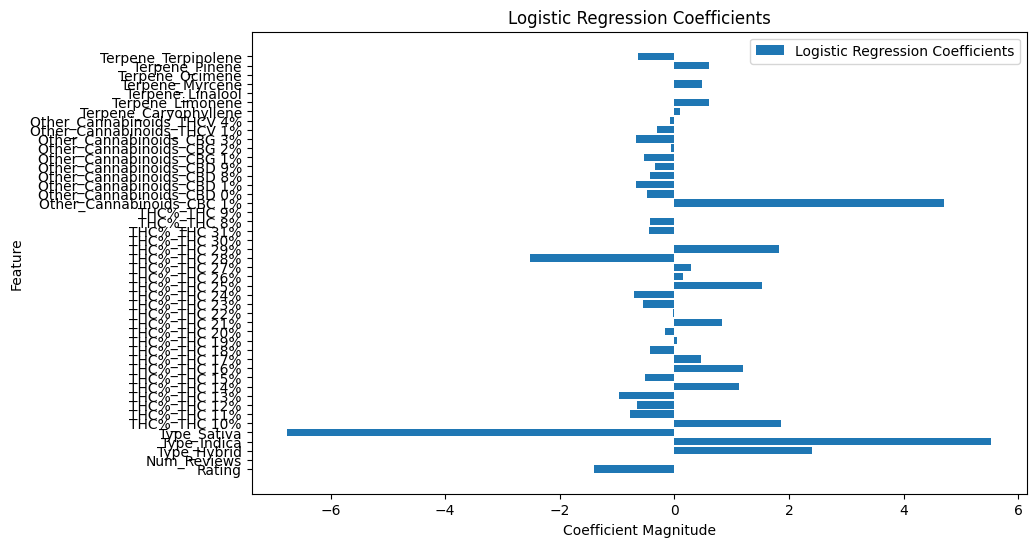

In [135]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Load data from CSV
df = pd.read_csv('https://raw.githubusercontent.com/zeroday-zaddy/cs422-project/main/data/strains_cleaned.csv')

# Drop rows with missing values
df = df.dropna()

# Define features (X) and binary target variable (y)
X_columns = ['Type', 'Rating', 'Num_Reviews', 'THC%', 'Other_Cannabinoids', 'Terpene']
y_column = 'Main_Effect'

# Binary classification: 1 if Main_Effect is "Sleepy", 0 otherwise
df['Binary_Target'] = (df[y_column] == 'Sleepy').astype(int)

X = df[X_columns]
y = df['Binary_Target']

# Encode categorical variables
X_encoded = pd.get_dummies(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, random_state=42)

# Create and train a Logistic Regression model
# Had to add C to increase accuracy
logistic_regression = LogisticRegression(C=100, random_state=42, max_iter=1000)
logistic_regression.fit(X_train, y_train)

# Make predictions
y_pred = logistic_regression.predict(X_test)

# Access the coefficients
coefficients = logistic_regression.coef_[0]

# Map coefficients to feature names
feature_importance = dict(zip(X_encoded.columns, coefficients))

# Print training set score
train_score = logistic_regression.score(X_train, y_train)
print("Training Set Score:", train_score)

# Print test set score
test_score = logistic_regression.score(X_test, y_test)
print("Test Set Score:", test_score)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print feature importance
print("Feature Importance:")
for feature, importance in sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"{feature}: {importance}")

# Plot coefficients
plt.figure(figsize=(10, 6))
plt.barh(list(feature_importance.keys()), list(feature_importance.values()))
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.legend(['Logistic Regression Coefficients'])
plt.show()


Confusion Matrix for Sleepy

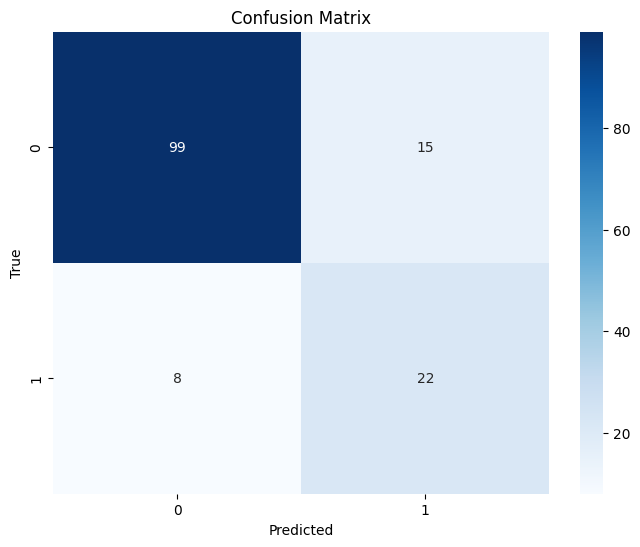

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the true labels y_test and predicted labels y_pred
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [150]:
# Example new data for prediction (replace with your actual data)
new_data = pd.DataFrame({
    'Rating': [0],  # replace with your value
    'Num_Reviews': [0],  # replace with your value
    'Type_Hybrid': [0],  # replace with your value
    'Type_Indica': [1],  # replace with your value
    'Type_Sativa': [0],  # replace with your value
    'THC%_THC 10%': [0],  # replace with your value
    'THC%_THC 11%': [0],  # replace with your value
    'THC%_THC 12%': [0],  # replace with your value
    'THC%_THC 13%': [0],  # replace with your value
    'THC%_THC 14%': [0],  # replace with your value
    'THC%_THC 15%': [0],  # replace with your value
    'THC%_THC 16%': [0],  # replace with your value
    'THC%_THC 17%': [0],  # replace with your value
    'THC%_THC 18%': [0],  # replace with your value
    'THC%_THC 19%': [0],  # replace with your value
    'THC%_THC 20%': [0],  # replace with your value
    'THC%_THC 21%': [0],  # replace with your value
    'THC%_THC 22%': [0],  # replace with your value
    'THC%_THC 23%': [0],  # replace with your value
    'THC%_THC 24%': [0],  # replace with your value
    'THC%_THC 25%': [0],  # replace with your value
    'THC%_THC 26%': [0],  # replace with your value
    'THC%_THC 27%': [0],  # replace with your value
    'THC%_THC 28%': [0],  # replace with your value
    'THC%_THC 29%': [0],  # replace with your value
    'THC%_THC 30%': [0],  # replace with your value
    'THC%_THC 31%': [0],  # replace with your value
    'THC%_THC 8%': [0],  # replace with your value
    'THC%_THC 9%': [0],  # replace with your value
    'Other_Cannabinoids_CBC 1%': [0],  # replace with your value
    'Other_Cannabinoids_CBD 0%': [0],  # replace with your value
    'Other_Cannabinoids_CBD 1%': [0],  # replace with your value
    'Other_Cannabinoids_CBD 8%': [0],  # replace with your value
    'Other_Cannabinoids_CBD 9%': [0],  # replace with your value
    'Other_Cannabinoids_CBG 1%': [0],  # replace with your value
    'Other_Cannabinoids_CBG 2%': [0],  # replace with your value
    'Other_Cannabinoids_CBG 3%': [0],  # replace with your value
    'Other_Cannabinoids_THCV 1%': [0],  # replace with your value
    'Other_Cannabinoids_THCV 4%': [0],  # replace with your value
    'Terpene_Caryophyllene': [0],  # replace with your value
    'Terpene_Limonene': [0],  # replace with your value
    'Terpene_Linalool': [0],  # replace with your value
    'Terpene_Myrcene': [0],  # replace with your value
    'Terpene_Ocimene': [0],  # replace with your value
    'Terpene_Pinene': [0],  # replace with your value
    'Terpene_Terpinolene': [0],  # replace with your value
})

# Encode categorical variables
new_data_encoded = pd.get_dummies(new_data)

# Make prediction
prediction = logistic_regression.predict(new_data_encoded)

# Display the prediction
print("Predicted Class:", prediction)


Predicted Class: [1]


Example using Logistic Regression to determine if Main Effect is Energetic

Training Set Score: 0.9395348837209302
Test Set Score: 0.8680555555555556
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       124
           1       0.52      0.60      0.56        20

    accuracy                           0.87       144
   macro avg       0.73      0.76      0.74       144
weighted avg       0.88      0.87      0.87       144

Feature Importance:
Other_Cannabinoids_CBD 1%: 6.769140821262203
Type_Sativa: 5.308408620342054
THC%_THC 13%: -5.010869797954409
THC%_THC 11%: -4.736319366942162
THC%_THC 12%: 3.598058994387402
Terpene_Ocimene: 3.3906805405990537
THC%_THC 15%: 2.5763887453427117
Other_Cannabinoids_CBC 1%: -2.4528322719665674
THC%_THC 25%: 2.441848904881602
Terpene_Pinene: -2.3922278974186097
THC%_THC 20%: 2.1122010220658973
Type_Indica: -2.0842357768034776
Other_Cannabinoids_THCV 1%: -1.9848933248663516
Rating: -1.8413325928621298
THC%_THC 19%: 1.7526501580029383
Terpene_Limonene: 1.458

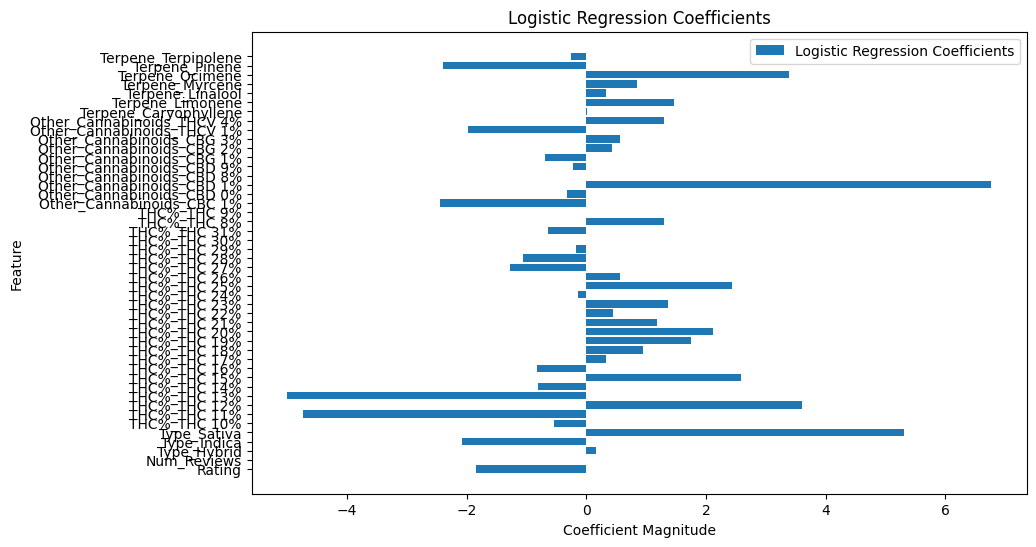

In [142]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Load data from CSV
df = pd.read_csv('https://raw.githubusercontent.com/zeroday-zaddy/cs422-project/main/data/strains_cleaned.csv')

# Drop rows with missing values
df = df.dropna()

# Define features (X) and binary target variable (y)
X_columns = ['Type', 'Rating', 'Num_Reviews', 'THC%', 'Other_Cannabinoids', 'Terpene']
y_column = 'Main_Effect'

# Binary classification: 1 if Main_Effect is "Energetic", 0 otherwise
df['Binary_Target'] = (df[y_column] == 'Energetic').astype(int)

X = df[X_columns]
y = df['Binary_Target']

# Encode categorical variables
X_encoded = pd.get_dummies(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, random_state=42)

# Create and train a Logistic Regression model
logistic_regression = LogisticRegression(C=100, random_state=42, max_iter=1000)

logistic_regression.fit(X_train, y_train)

# Make predictions
y_pred = logistic_regression.predict(X_test)

# Access the coefficients
coefficients = logistic_regression.coef_[0]

# Map coefficients to feature names
feature_importance = dict(zip(X_encoded.columns, coefficients))

# Print training set score
train_score = logistic_regression.score(X_train, y_train)
print("Training Set Score:", train_score)

# Print test set score
test_score = logistic_regression.score(X_test, y_test)
print("Test Set Score:", test_score)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print feature importance
print("Feature Importance:")
for feature, importance in sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"{feature}: {importance}")

# Plot coefficients
plt.figure(figsize=(10, 6))
plt.barh(list(feature_importance.keys()), list(feature_importance.values()))
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.legend(['Logistic Regression Coefficients'])
plt.show()



Confusion Matrix for Energetic

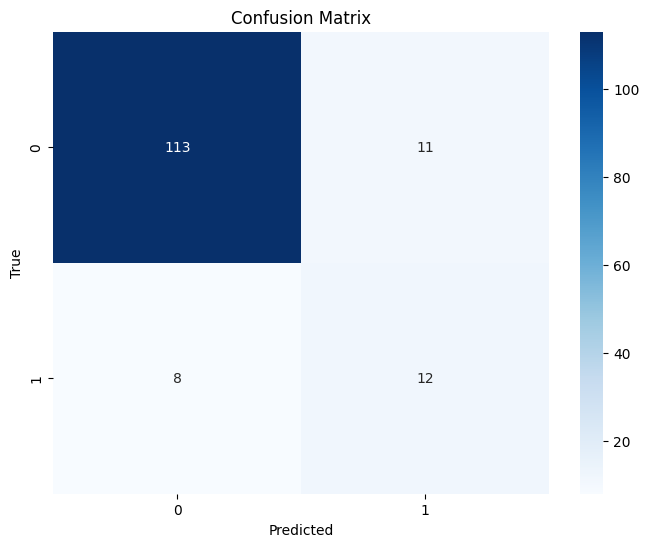

In [79]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the true labels y_test and predicted labels y_pred
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Feature Importance for Energetic

Ridge Regression for Sleepy

In [84]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import classification_report, accuracy_score

# Load data from CSV
df = pd.read_csv('https://raw.githubusercontent.com/zeroday-zaddy/cs422-project/main/data/strains_cleaned.csv')

# Drop rows with missing values
df = df.dropna()

# Define features (X) and binary target variable (y)
X_columns = ['Type', 'Rating', 'Num_Reviews', 'THC%', 'Other_Cannabinoids', 'Terpene']
y_column = 'Main_Effect'

# Binary classification: 1 if Main_Effect is "Sleepy", 0 otherwise
df['Binary_Target'] = (df[y_column] == 'Sleepy').astype(int)

X = df[X_columns]
y = df['Binary_Target']

# Encode categorical variables
X_encoded = pd.get_dummies(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, random_state=42)

# Create and train a Ridge Regression model
ridge_regression = Ridge(random_state=42)
ridge_regression.fit(X_train, y_train)

# Make predictions
y_pred = ridge_regression.predict(X_test)

# Convert predictions to binary (1 or 0)
y_pred_binary = (y_pred > 0.5).astype(int)

# Evaluate the model
print("Accuracy on test set:", accuracy_score(y_test, y_pred_binary))
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))


Accuracy on test set: 0.8333333333333334
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.83      0.89       114
           1       0.57      0.83      0.68        30

    accuracy                           0.83       144
   macro avg       0.76      0.83      0.78       144
weighted avg       0.87      0.83      0.84       144



Lasso Regression for Sleepy

In [92]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import classification_report, accuracy_score

# Load data from CSV
df = pd.read_csv('https://raw.githubusercontent.com/zeroday-zaddy/cs422-project/main/data/strains_cleaned.csv')

# Drop rows with missing values
df = df.dropna()

# Define features (X) and binary target variable (y)
X_columns = ['Type', 'Rating', 'Num_Reviews', 'THC%', 'Other_Cannabinoids', 'Terpene']
y_column = 'Main_Effect'

# Binary classification: 1 if Main_Effect is "Sleepy", 0 otherwise
df['Binary_Target'] = (df[y_column] == 'Sleepy').astype(int)

X = df[X_columns]
y = df['Binary_Target']

# Encode categorical variables
X_encoded = pd.get_dummies(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, random_state=42)

# Create and train a Lasso Regression model
lasso_regression = Lasso(random_state=42)
lasso_regression.fit(X_train, y_train)

# Make predictions
y_pred = lasso_regression.predict(X_test)

# Convert predictions to binary (1 or 0)
y_pred_binary = (y_pred > 0.3).astype(int)

# Evaluate the model
print("Accuracy on test set:", accuracy_score(y_test, y_pred_binary))
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))


Accuracy on test set: 0.7777777777777778
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.98      0.88       114
           1       0.00      0.00      0.00        30

    accuracy                           0.78       144
   macro avg       0.39      0.49      0.44       144
weighted avg       0.62      0.78      0.69       144



Support Vector Machine using Sleepy with 3 different hyperparameters

In [94]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Load data from CSV
df = pd.read_csv('https://raw.githubusercontent.com/zeroday-zaddy/cs422-project/main/data/strains_cleaned.csv')

# Drop rows with missing values
df = df.dropna()

# Define features (X) and binary target variable (y)
X_columns = ['Type', 'Rating', 'Num_Reviews', 'THC%', 'Other_Cannabinoids', 'Terpene']
y_column = 'Main_Effect'

# Binary classification: 1 if Main_Effect is "Sleepy", 0 otherwise
df['Binary_Target'] = (df[y_column] == 'Sleepy').astype(int)

X = df[X_columns]
y = df['Binary_Target']

# Encode categorical variables
X_encoded = pd.get_dummies(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, random_state=42)

# Specify different values of C to try
C_values = [0.1, 1, 10]

for C in C_values:
    # Create and train a Linear SVM model with different C values
    linear_svm = SVC(kernel='linear', C=C, random_state=42)
    linear_svm.fit(X_train, y_train)

    # Make predictions
    y_pred = linear_svm.predict(X_test)

    # Evaluate the model
    print(f"Accuracy on test set for C={C}: {accuracy_score(y_test, y_pred)}")
    print(f"Classification Report for C={C}:\n{classification_report(y_test, y_pred)}")
    print("----------------------------------------------------")


Accuracy on test set for C=0.1: 0.8333333333333334
Classification Report for C=0.1:
              precision    recall  f1-score   support

           0       0.95      0.83      0.89       114
           1       0.57      0.83      0.68        30

    accuracy                           0.83       144
   macro avg       0.76      0.83      0.78       144
weighted avg       0.87      0.83      0.84       144

----------------------------------------------------
Accuracy on test set for C=1: 0.8402777777777778
Classification Report for C=1:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       114
           1       0.58      0.83      0.68        30

    accuracy                           0.84       144
   macro avg       0.77      0.84      0.79       144
weighted avg       0.87      0.84      0.85       144

----------------------------------------------------
Accuracy on test set for C=10: 0.8402777777777778
Classification Report for 

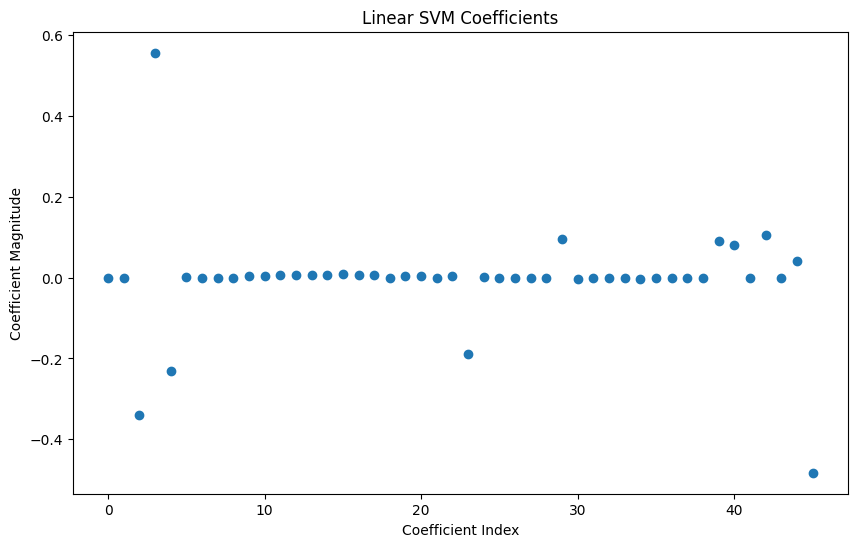

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Load data from CSV
df = pd.read_csv('https://raw.githubusercontent.com/zeroday-zaddy/cs422-project/main/data/strains_cleaned.csv')

# Drop rows with missing values
df = df.dropna()

# Define features (X) and binary target variable (y)
X_columns = ['Type', 'Rating', 'Num_Reviews', 'THC%', 'Other_Cannabinoids', 'Terpene']
y_column = 'Main_Effect'

# Binary classification: 1 if Main_Effect is "Sleepy", 0 otherwise
df['Binary_Target'] = (df[y_column] == 'Sleepy').astype(int)

X = df[X_columns]
y = df['Binary_Target']

# Encode categorical variables
X_encoded = pd.get_dummies(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, random_state=42)

# Standardize features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train a Linear SVM model
linear_svm = SVC(kernel='linear', C=1, random_state=42)
linear_svm.fit(X_train_scaled, y_train)

# Get feature coefficients and names
coef = linear_svm.coef_.ravel()
feature_names = X_encoded.columns

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(coef)), coef, marker='o')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Magnitude')
plt.title('Linear SVM Coefficients')
plt.show()
